<a href="https://colab.research.google.com/github/polis-community/red-dwarf/blob/main/docs/notebooks/polis-implementation-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --quiet --no-cache-dir git+https://github.com/polis-community/red-dwarf.git@main

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.1/116.1 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 194.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 158.9 MB/s eta 0:00:00


In [2]:
from reddwarf.data_loader import Loader
import json
import numpy as np

# Topic: What were the most significant developments in tech and politics in 2018?
# 5 groups, 65 ptpts (56 grouped), 43 comments (open)
REPORT_ID="r2dfw8eambusb8buvecjt"
# REPORT_ID="r6ipxzfudddppwesbmtmn" # Alternative Polis convo

print(f"Loading data from https://pol.is/report/{REPORT_ID}")

# We'll use the data_loader utility to simply load vote data.
loader = Loader(polis_id=REPORT_ID)
votes = loader.votes_data

# Show what our raw vote data looks like:
print(json.dumps(votes[0], indent=2))

# Show what our raw statement data looks like:
statements = loader.comments_data
print(json.dumps(statements[0], indent=2))

# We need this for a little helper later.
math_data = loader.math_data

Loading data from https://pol.is/report/r2dfw8eambusb8buvecjt
{
  "participant_id": 0,
  "statement_id": 0,
  "vote": 1,
  "weight_x_32767": 0,
  "modified": 1544544810393.0,
  "conversation_id": "6jrufhr6dp",
  "datetime": null
}
{
  "txt": "I feel Blockchain technologies have been over-hyped.",
  "statement_id": 1,
  "created": "2018-12-11T16:13:43.605000Z",
  "tweet_id": null,
  "quote_src_url": null,
  "is_seed": false,
  "is_meta": false,
  "lang": "en",
  "participant_id": 0,
  "velocity": 1,
  "moderated": -1,
  "active": true,
  "agree_count": 12,
  "disagree_count": 2,
  "pass_count": 1,
  "count": 15,
  "conversation_id": "6jrufhr6dp",
  "datetime": null
}


In [3]:
# Now we use out custom polis implementation to recreate the Polis calculations.
from reddwarf.implementations.polis import run_clustering
from reddwarf.utils.statements import process_statements
from reddwarf.utils.polismath import get_corrected_centroid_guesses

# In this conversation, any -1 is moderated out. Matches upstream behavior.
# TODO: Investigate why is_strict_moderation doesn't affect this.
_, _, mod_out_statement_ids, _ = process_statements(statements)
print(f"{math_data['mod-out']=}")
print(f"{mod_out_statement_ids=}")

# We can run this from scratch, but kmeans is non-deterministic and might find slightly different clusters
# or even different k-values (number of groups) if the silhouette scores it finds are better.
# To show how to reproduce Polis results, we'll set init guess coordinates that we know polis platform got:
init_cluster_center_guesses = get_corrected_centroid_guesses(math_data, skip_correction=False)
print(f"{init_cluster_center_guesses=}")

math_data['mod-out']=[0, 1, 31]
mod_out_statement_ids=[0, 1, 31]
init_cluster_center_guesses=[[2.3249928691116573, -0.660737300795657], [-0.2555363550500295, 0.23787153431450953], [-1.2703643531444606, -1.913074376569441], [1.3341169243032838, 1.4244873357833063], [-3.2582815788575115, 1.4124353685383775]]


In [4]:
# Now with those guessed cluster centers seeded, we'll run the whole calculation from raw vote data.
result = run_clustering(
    votes=votes,
    mod_out_statement_ids=mod_out_statement_ids,
    # If clustering is getting ready to find a new k, more need to uncomment
    # this to properly reproduce Polis visualization.
    #
    # force_group_count=len(init_cluster_center_guesses),
    init_centers=init_cluster_center_guesses,
    # Polis has some edge-cases logic that keeps arbitrary [early] participants in
    # the clustering algorithm for reasons that are hard to reproduce, so we
    # borrow these.
    # See: https://github.com/compdemocracy/polis/pull/1893#issuecomment-2654666421
    keep_participant_ids=math_data["in-conv"],
)

print(result.projected_participants.head(5))
print(result.projected_statements.head(5))

                       x         y  cluster_id
participant_id                                
0               1.973022  1.268457           3
1               3.430412 -1.167209           0
2               1.016923  0.471388           3
3               1.126139  0.083078           3
4               1.260190  0.808216           3
                     x         y
statement_id                    
0             0.000000  0.000000
1             0.000000  0.000000
2             0.931253  0.267837
3             0.871370 -1.240633
4             1.250362 -0.635842


Calculating convex hulls around clusters...
Hull 0, bounding 11 points
Hull 1, bounding 20 points
Hull 2, bounding 10 points
Hull 3, bounding 9 points
Hull 4, bounding 6 points


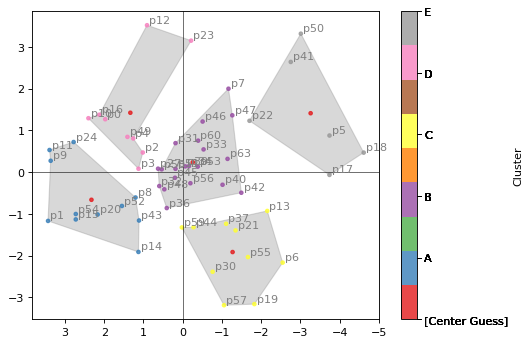

In [5]:
from reddwarf.data_presenter import generate_figure_polis

# flip_y sometimes needed to look like Polis interface
generate_figure_polis(result, show_guesses=True, flip_y=False)
# Note: the red points (group '-1') are the cluster center guesses that we fed into the KMeans algorithm.


You can see that this looks exactly how the Polis visualization looks!

![screenshot of the polis report](https://imgur.com/blkIEtW.png)

In [6]:
from reddwarf.utils.stats import select_representative_statements
from reddwarf.data_presenter import print_repness

repness = select_representative_statements(
    grouped_stats_df=result.group_comment_stats,
    mod_out_statement_ids=mod_out_statement_ids,
)
print_repness(repness=repness, statements_data=statements)


GROUP A
* Major regulatory interference in the operation of Facebook's algorithms and policies is now definitely going to happen, in the USA.
   100% of those in group A who voted on statement 11 agreed.

* This year the SideWalk Labs project in Toronto brought the 'city of surveillance' discussion front and center.
   100% of those in group A who voted on statement 33 agreed.

* A significant number of governing elites lost fear of having an internet connected microphone in their house, listening to everything
   80% of those in group A who voted on statement 17 agreed.

* "Access and Assistance" laws passed by Australian Parliament give a blank cheque to any democracy that wants to install device backdoors.
   100% of those in group A who voted on statement 36 agreed.

* Facebook implementing local news and local government alerts directly into its product
   100% of those in group A who voted on statement 15 disagreed.


GROUP B
* Swing Left's campaign in waiting: building grassroot